In [7]:
# --- CELL 1: SETUP & DATA LOADING ---
# Setup environment, load raw datasets, and prepare the dataframe.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle

sns.set_style("whitegrid")

INPUT_FILE = "../data/news_dataset.csv"

try:
    # Load raw data
    print(f"Loading dataset from {INPUT_FILE}...")
    df = pd.read_csv(INPUT_FILE)

    # Remove missing values
    df = df.dropna(subset=['text', 'title'])

    # Shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Datasets were loaded successfully!")
    print(f"  Total articles: {df.shape[0]}")
    print(f"  Class Balance (0=Fake, 1=Real):\n{df['labels'].value_counts()}")
    
except FileNotFoundError:
    print("ERROR: Could not find  in ../data/")

df.head()

Loading dataset from ../data/news_dataset.csv...
Datasets were loaded successfully!
  Total articles: 73018
  Class Balance (0=Fake, 1=Real):
labels
0    36509
1    36509
Name: count, dtype: int64


,title,text,labels
0,Boiler Room #93 – The Outgoing Head of Hydra,Tune in to the Alternate Current Radio Network...,0
1,Giant Lovell radio telescope at Jodrell Bank t...,The giant Lovell radio telescope at Jodrell Ba...,1
2,Bundy Case Ruled a Mistrial – Will Federal Cas...,Mark Anderson 21st Century WireThe Greek phil...,0
3,HUMILIATING: Democrats Use RUSSIAN WARSHIPS As...,Maybe Hillary s Russian uranium deal included ...,0
4,Rum,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,0


In [8]:
# --- CELL 2: DATA PREPROCESSING ---
# Define and apply the text cleaning pipeline: lowercase, regex removal (URLs, HTML), 
# stopword removal, and lemmatization to standardize input data.

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = str(text).lower()

    # --- ANTI-BIAS CLEANING  ---
    # Remove patterns like "washington (reuters) -" from the start
    text = re.sub(r'^.*?\s\(reuters\)\s-\s', '', text)
    # Remove standalone agency names
    text = re.sub(r'\b(reuters|bbc|cnn|ap|united press international)\b', '', text)

    # Remove media tags (VIDEO), [VIDEO], (IMAGE), [JPG], etc.
    text = re.sub(r'[\(\[]\s*(video|image|img|photos?|watch).*?[\)\]]', '', text)

    # Remove "WATCH:" or "IMAGE:" often found at start of fake news
    text = re.sub(r'^(watch|image|video)\s?:\s?', '', text)

    # Remove URLs (http/https/www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove blank spaces 
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization 
    words = text.split()

    # Remove stopwords and apply Lemmatization
    cleaned_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    # Reconstruct the text
    return ' '.join(cleaned_words)

print("Starting text cleaning process... (This may take 1-2 minutes).")
df['full_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['full_text'].apply(clean_text)

initial_count = len(df)
df = df[df['clean_text'].str.strip().astype(bool)]
final_count = len(df)

print(f"Preprocessing completed. Removed {initial_count - final_count} empty rows.")
print("-" * 50)

print("Sample of processed data:")
print(df[['title', 'clean_text']].head())


Starting text cleaning process... (This may take 1-2 minutes).
Preprocessing completed. Removed 97 empty rows.
--------------------------------------------------
Sample of processed data:
                                               title  \
0       Boiler Room #93 – The Outgoing Head of Hydra   
1  Giant Lovell radio telescope at Jodrell Bank t...   
2  Bundy Case Ruled a Mistrial – Will Federal Cas...   
3  HUMILIATING: Democrats Use RUSSIAN WARSHIPS As...   
4                                                Rum   

                                          clean_text  
0  boiler room outgoing head hydra tune alternate...  
1  giant lovell radio telescope jodrell bank beco...  
2  bundy case ruled mistrial federal case soon cr...  
3  humiliating democrat use russian warship backd...  
4  rum right reverand pope jeremiah goldstien say...  


In [9]:
# --- CELL 3: FEATURE ENGINEERING (TF-IDF) & SPLIT ---
# Split the dataset into training and testing sets, then convert text to numerical vectors using TF-IDF.
# Saves the vectorizer and processed data to disk.

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os

OUTPUT_DIR = '../models/classic_model'

# Create a specific directory to store the model artifacts
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created '{OUTPUT_DIR}' directory")

X = df['clean_text']
y = df['labels']

print("Splitting data into Training and Testing sets...")
# Split data: 80% for training, 20% for testing. 'stratify=y' maintains class balance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

print("Vectorizing text (converting words in numbers)...")
# Initialize TF-IDF Vectorizer (limit to top 5000 most frequent words to reduce noise)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit vectorizer on Training data only (to avoid data leakage), then transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save the vectorizer and processed data for later use (in the API)
with open(f'{OUTPUT_DIR}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open(f'{OUTPUT_DIR}/train_data.pkl', 'wb') as f:
    pickle.dump((X_train_tfidf, y_train), f)
with open(f'{OUTPUT_DIR}/test_data.pkl', 'wb') as f:
    pickle.dump((X_test_tfidf, y_test), f)

print(f"Vectorizer and data saved in '{OUTPUT_DIR}' folder.")
print(f"Matrix Shape: {X_train_tfidf.shape} (Rows, Features).")

Splitting data into Training and Testing sets...
Training samples: 58336
Testing samples: 14585
Vectorizing text (converting words in numbers)...
Vectorizer and data saved in '../models/classic_model' folder.
Matrix Shape: (58336, 5000) (Rows, Features).


In [10]:
# --- CELL 4: MODEL TRAINING (LOGISTIC REGRESSION) ---
# Initialize the Logistic Regression model, train it on the TF-IDF features, 
# and save the trained model to disk for the final application.

from sklearn.linear_model import LogisticRegression
import pickle

print("Training Logistic Regression Model...")

# Initialize the model
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model_lr.fit(X_train_tfidf, y_train)

print("Model trained successfully!")

# Save the trained model
with open(f'{OUTPUT_DIR}/model_lr.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

print(f"Model saved as 'model_lr.pkl', in '{OUTPUT_DIR}' folder.")


Training Logistic Regression Model...
Model trained successfully!
Model saved as 'model_lr.pkl', in '../models/classic_model' folder.


Testing the model on unseen data

Model accuracy: 0.9202 (92.02%)
--------------------------------------------------
Detailed Report:
              precision    recall  f1-score   support

   Fake News       0.92      0.92      0.92      7283
   Real News       0.92      0.92      0.92      7302

    accuracy                           0.92     14585
   macro avg       0.92      0.92      0.92     14585
weighted avg       0.92      0.92      0.92     14585



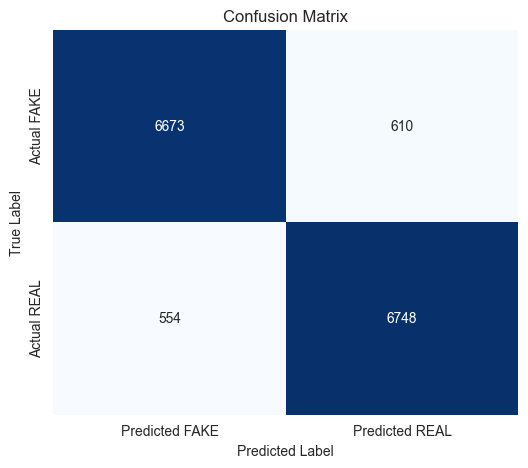

In [11]:
# --- CELL 5: MODEL EVALUATION ---
# Evaluate the trained model's performance on the unseen test set using metrics 
# like accuracy, precision, recall, and a visual confusion matrix.

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Testing the model on unseen data")
# Generate predictions on the test data (which the model has never seen)
y_pred = model_lr.predict(X_test_tfidf)

# Calculate and print overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel accuracy: {accuracy:.4f} ({(accuracy*100):.2f}%)")
print("-" * 50)

# Print detailed metrics (Precision, Recall, F1-Score) per class
print("Detailed Report:")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News']))

cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix using a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted FAKE', 'Predicted REAL'], yticklabels=['Actual FAKE', 'Actual REAL'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Initializing LIME Explainer...
--------------------------------------------------
Analyzing Article ID: 66710
Label: FAKE NEWS
--------------------------------------------------
ORIGINAL TEXT (Snippet):
 Mueller Just Told Trump To F*ck Off With His Threats, Expands Probe To Trump Family Finances
On Wednesday, Donald Trump warned the special counsel investigating the Russia scandal not to look into his business or personal finances and that s exactly like saying,  Hey, Special Counsel Robert Mueller, look into my finances!  Well, that s just what happened. It s like after robbing a bank and the po...

CLEANED TEXT (Model Input):
mueller told trump fck threat expands probe trump family finance wednesday donald trump warned special counsel investigating russia scandal look business personal finance exactly like saying hey special counsel robert mueller look finance well happened like robbing bank police stop running red light say look trunk part probe possible tie donald trump campaign ru

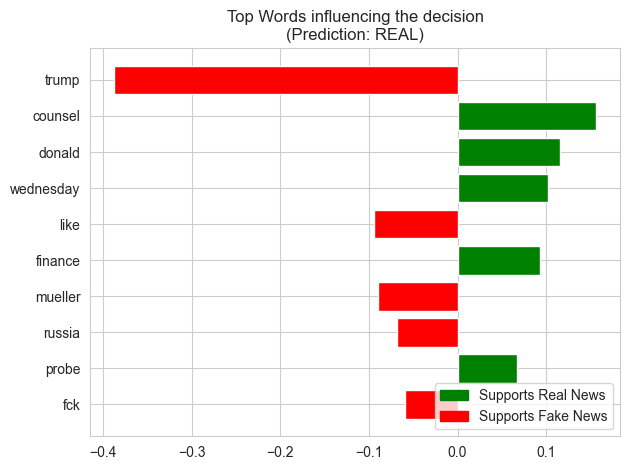

In [12]:
# --- CELL 6: EXPLAINABILITY (LIME) ---
# Use LIME to visualize which words influenced the model's decision for a specific article.

from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("Initializing LIME Explainer...")

# Create a pipeline that connects the vectorizer to the model
# This allows LIME to pass raw text, which gets vectorized automatically before prediction
pipeline = make_pipeline(vectorizer, model_lr)
explainer = LimeTextExplainer(class_names=['Fake News', 'Real News'])

# Select a random article from the test set for analysis
rand_idx = random.randint(0, len(X_test) - 1)
original_idx = y_test.index[rand_idx]

# Retrieve original (raw) text and cleaned text for comparison
raw_text = df.loc[original_idx]['title'] + "\n" + df.loc[original_idx]['text']
clean_text_sample = df.loc[original_idx]['clean_text']
true_label = df.loc[original_idx]['labels']

print("-" * 50)
print(f"Analyzing Article ID: {original_idx}")
print(f"Label: {'REAL NEWS' if true_label == 1 else 'FAKE NEWS'}")
print("-" * 50)
print("ORIGINAL TEXT (Snippet):")
print(f"{raw_text[:400]}...")
print("\nCLEANED TEXT (Model Input):")
print(f"{clean_text_sample[:400]}...")
print("-" * 50)

try:
    # Generate the explanation for the specific instance
    # We ask for the top 10 features (words) that influenced the decision
    exp = explainer.explain_instance(
        clean_text_sample, 
        pipeline.predict_proba, 
        num_features=10
    )
    
    # Get prediction probabilities
    probs = pipeline.predict_proba([clean_text_sample])[0]
    fake_prob = probs[0]
    real_prob = probs[1]
    
    print(f"\nModel Confidence:")
    print(f"Fake: {fake_prob:.2%} | Real: {real_prob:.2%}")

    # Visualize the results using Matplotlib
    fig = exp.as_pyplot_figure()
    green_patch = mpatches.Patch(color='green', label='Supports Real News')
    red_patch = mpatches.Patch(color='red', label='Supports Fake News')
    
    plt.legend(handles=[green_patch, red_patch], loc='lower right')
    plt.title(f"Top Words influencing the decision\n(Prediction: {'REAL' if real_prob > fake_prob else 'FAKE'})")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")